In [1]:
%load_ext autoreload
%autoreload 2    

In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import torchmetrics

import albumentations as A
from albumentations.pytorch import ToTensorV2


In [3]:
import numpy as np
# ! pip install opencv-python==4.5.5.64
import cv2 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
batch_size = 8

# Custom loss

In [6]:
#PyTorch
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer    
        inputs = F.sigmoid(inputs)
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs.to(float), targets.to(float), reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

# Augmentation

In [7]:
from data_loader import PH2, DRIVE

# Model

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 1, 3, padding=1)
        
    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e1 = F.relu(self.enc_conv1(e0))
        e2 = F.relu(self.enc_conv2(e1))

        # no activation
        e3 = self.enc_conv3(e2)
        
        return e3

# Train

In [9]:
import torch
from torchmetrics import Metric

class Sensitivity(torchmetrics.Metric):
    def __init__(self, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.add_state("tp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fn", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        # Convert predictions to binary values (0 or 1)
        preds = torch.round(preds)

        # Calculate true positives and false negatives
        tp = torch.sum((preds >= 0.5) & (target == 1))
        fn = torch.sum((preds < 0.5) & (target == 1))

        # Update state variables
        self.tp += tp
        self.fn += fn

    def compute(self):
        # Calculate sensitivity/recall
        sensitivity = self.tp.float() / (self.tp + self.fn + 1e-12)

        return sensitivity


In [10]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader, test_loader):

    train_loss = []
    val_loss = []


    metric_dict = {
                'train_dice': torchmetrics.Dice().to(device),
                'train_iou': torchmetrics.JaccardIndex('binary').to(device),
                'train_acc': torchmetrics.Accuracy('binary').to(device),
                'train_sens': Sensitivity().to(device),
                'train_spec': torchmetrics.Specificity('binary').to(device),
                
                'val_dice': torchmetrics.Dice().to(device),
                'val_iou': torchmetrics.JaccardIndex('binary').to(device),
                'val_acc': torchmetrics.Accuracy('binary').to(device),
                'val_sens': Sensitivity().to(device),
                'val_spec': torchmetrics.Specificity('binary').to(device),

                                
                'test_dice': torchmetrics.Dice().to(device),
                'test_iou': torchmetrics.JaccardIndex('binary').to(device),
                'test_acc': torchmetrics.Accuracy('binary').to(device),
                'test_sens': Sensitivity().to(device),
                'test_spec': torchmetrics.Specificity('binary').to(device),
               }

    out_dict = {
                
                'train_loss':[],
                'train_dice': [],
                'train_iou': [],
                'train_acc': [],
                'train_sens': [],
                'train_spec': [],

                'val_loss':[],
                'val_dice': [],
                'val_iou':[],
                'val_acc': [],
                'val_sens': [],
                'val_spec': [],

                                
                'test_dice': [],
                'test_iou': [],
                'test_acc': [],
                'test_sens': [],
                'test_spec': [],
    }

    
    for epoch in range(epochs):
        tic = time()
        
        avg_loss = 0
        avg_loss_val = 0
        
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            loss = loss_fn(Y_pred, Y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)

            metric_dict['train_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))

            
        toc = time()

        model.eval()  # testing mode
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            loss_test = loss_fn(F.sigmoid(Y_pred), Y_batch)  # forward-pass
            avg_loss_val += loss / len(val_loader)

            metric_dict['val_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            
        
        train_loss.append(avg_loss.detach().cpu())
        val_loss.append(avg_loss_val.detach().cpu())

        #plt.plot(train_loss, np.arange(len(train_loss)))
        #plt.plot(test_loss, np.arange(len(test_loss)))
                 
        for metric in ['dice', 'acc', 'iou', 'sens', 'spec']:
            out_dict['train_' + metric].append(metric_dict['train_' + metric].compute().detach().cpu())
            out_dict['val_' + metric].append(metric_dict['val_' + metric].compute().detach().cpu())

        
        
        print(f"Loss train: {avg_loss:.3f}\t Train dice: {metric_dict['train_dice'].compute():.3f}\t, Train IOU: {metric_dict['train_iou'].compute()}")

        if epoch%20 ==0: 
            im, lab = next(iter(test_loader))
            out = model(im.cuda())
            plt.imshow(F.sigmoid(out)[0].squeeze().detach().cpu() > 0.5)
            plt.show()
            
    model.eval()  # testing mode
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        
        Y_pred = model(X_batch)
        Y_batch = Y_batch.unsqueeze(1)

        metric_dict['test_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))


    
    
    for metric in ['dice', 'acc', 'iou', 'sens', 'spec']:
        out_dict['test_' + metric].append(metric_dict['test_' + metric].compute().detach().cpu())

    out_dict['train_loss'] = train_loss
    out_dict['val_loss'] = val_loss
    
    
    return out_dict, metric_dict


    
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

# Other Dataset

In [11]:
size = 512
batch_size = 16

train_transform = A.Compose(
    [
        A.Resize(size, size),
        A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_CONSTANT),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(p=0.5),
        A.Flip(p=0.5),
        A.Normalize(),
        ToTensorV2(),
        
    ]
)

test_transform = A.Compose([A.Resize(size, size), 
                            A.Normalize(),
                            ToTensorV2()])

In [12]:
trainset = DRIVE(train=True, transform=train_transform) # test_transform for no augment
# valset = PH2('val', transform=test_transform)
testset = DRIVE(train=False, transform=test_transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8,)# persistent_workers=True, pin_memory=True)
# val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)

In [13]:
def visualize_img_and_label():

    
    plt.figure(figsize=(10, 4))
    for i in range(5):
        im, lb = trainset.__getitem__(i)
        plt.subplot(2, 5, i+1)
        plt.imshow(im.permute(1,2,0))
        plt.xticks([])
        plt.yticks([])
        plt.subplot(2, 5, 6+i)
        plt.imshow(lb) # lab.permute(1,2,0)
        plt.xticks([])
        plt.yticks([])
        plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


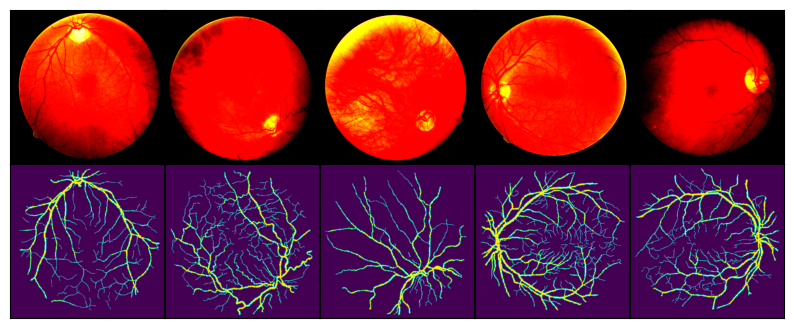

In [14]:


visualize_img_and_label()

In [15]:

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = F.sigmoid(inputs.view(-1)).to(float)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        
        return dice_loss


In [16]:
import torch
import torch.nn as nn

class ClassWeightedBCELoss(nn.Module):
    def __init__(self, weight=None, reduction='mean'):
        super(ClassWeightedBCELoss, self).__init__()
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        loss = nn.functional.binary_cross_entropy(inputs, targets, weight=self.weight, reduction=self.reduction)
        return loss

In [17]:
model = SimpleCNN().to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10]).cuda())

Loss train: 1.191	 Train dice: 0.171	, Train IOU: 0.09372660517692566


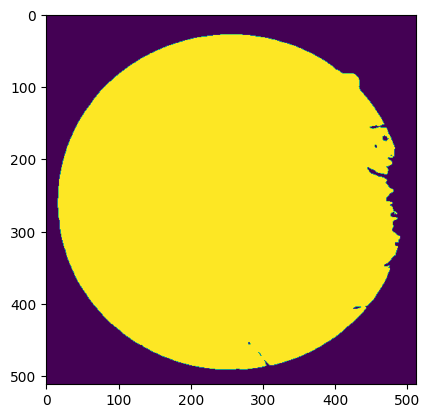

Loss train: 1.105	 Train dice: 0.191	, Train IOU: 0.10570978373289108
Loss train: 1.048	 Train dice: 0.199	, Train IOU: 0.11079135537147522
Loss train: 1.006	 Train dice: 0.204	, Train IOU: 0.11386868357658386
Loss train: 0.997	 Train dice: 0.209	, Train IOU: 0.1169414147734642
Loss train: 0.977	 Train dice: 0.214	, Train IOU: 0.1199183240532875
Loss train: 0.979	 Train dice: 0.218	, Train IOU: 0.12223728746175766
Loss train: 0.961	 Train dice: 0.220	, Train IOU: 0.12345656007528305
Loss train: 0.973	 Train dice: 0.221	, Train IOU: 0.12401430308818817
Loss train: 0.968	 Train dice: 0.221	, Train IOU: 0.12452112138271332
Loss train: 0.968	 Train dice: 0.223	, Train IOU: 0.12523172795772552
Loss train: 0.958	 Train dice: 0.224	, Train IOU: 0.12593823671340942
Loss train: 0.950	 Train dice: 0.225	, Train IOU: 0.12700916826725006
Loss train: 0.930	 Train dice: 0.227	, Train IOU: 0.1281675398349762
Loss train: 0.954	 Train dice: 0.229	, Train IOU: 0.12942475080490112
Loss train: 0.928	 Trai

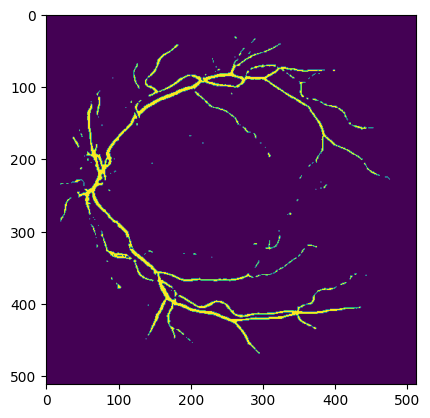

Loss train: 0.895	 Train dice: 0.240	, Train IOU: 0.13628904521465302
Loss train: 0.928	 Train dice: 0.241	, Train IOU: 0.13713927567005157
Loss train: 0.891	 Train dice: 0.243	, Train IOU: 0.138040229678154
Loss train: 0.926	 Train dice: 0.245	, Train IOU: 0.13963718712329865
Loss train: 0.897	 Train dice: 0.247	, Train IOU: 0.1410018652677536
Loss train: 0.887	 Train dice: 0.247	, Train IOU: 0.1410224884748459
Loss train: 0.885	 Train dice: 0.248	, Train IOU: 0.1416378617286682
Loss train: 0.860	 Train dice: 0.250	, Train IOU: 0.14310884475708008
Loss train: 0.846	 Train dice: 0.252	, Train IOU: 0.14438238739967346
Loss train: 0.865	 Train dice: 0.253	, Train IOU: 0.14502689242362976
Loss train: 0.842	 Train dice: 0.255	, Train IOU: 0.14598514139652252
Loss train: 0.847	 Train dice: 0.257	, Train IOU: 0.14741504192352295
Loss train: 0.824	 Train dice: 0.258	, Train IOU: 0.14823125302791595
Loss train: 0.848	 Train dice: 0.260	, Train IOU: 0.1492263823747635
Loss train: 0.816	 Train d

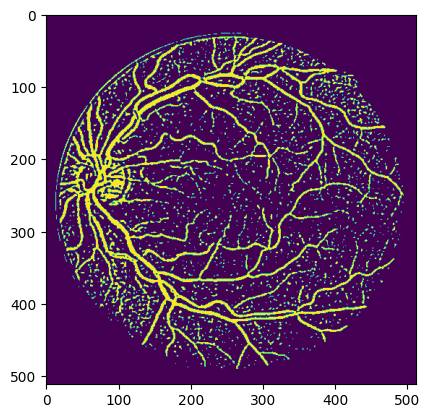

Loss train: 0.776	 Train dice: 0.270	, Train IOU: 0.15611031651496887
Loss train: 0.748	 Train dice: 0.272	, Train IOU: 0.15716934204101562
Loss train: 0.794	 Train dice: 0.274	, Train IOU: 0.1585630178451538
Loss train: 0.766	 Train dice: 0.275	, Train IOU: 0.15968598425388336
Loss train: 0.759	 Train dice: 0.276	, Train IOU: 0.16020475327968597
Loss train: 0.759	 Train dice: 0.278	, Train IOU: 0.16162769496440887
Loss train: 0.775	 Train dice: 0.280	, Train IOU: 0.16306549310684204
Loss train: 0.767	 Train dice: 0.281	, Train IOU: 0.16338710486888885
Loss train: 0.735	 Train dice: 0.282	, Train IOU: 0.16413797438144684
Loss train: 0.776	 Train dice: 0.284	, Train IOU: 0.1655784696340561
Loss train: 0.741	 Train dice: 0.286	, Train IOU: 0.16688719391822815
Loss train: 0.753	 Train dice: 0.287	, Train IOU: 0.16755811870098114
Loss train: 0.697	 Train dice: 0.289	, Train IOU: 0.16859331727027893
Loss train: 0.758	 Train dice: 0.290	, Train IOU: 0.16984181106090546
Loss train: 0.724	 Tra

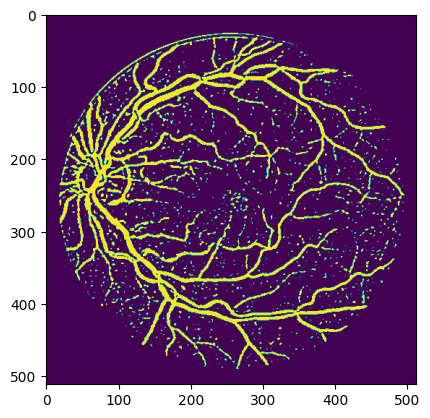

Loss train: 0.653	 Train dice: 0.302	, Train IOU: 0.17779935896396637
Loss train: 0.663	 Train dice: 0.304	, Train IOU: 0.17910660803318024
Loss train: 0.656	 Train dice: 0.306	, Train IOU: 0.18046341836452484
Loss train: 0.643	 Train dice: 0.308	, Train IOU: 0.18176351487636566
Loss train: 0.650	 Train dice: 0.309	, Train IOU: 0.18263259530067444
Loss train: 0.635	 Train dice: 0.311	, Train IOU: 0.1838526725769043
Loss train: 0.639	 Train dice: 0.312	, Train IOU: 0.18505443632602692
Loss train: 0.652	 Train dice: 0.314	, Train IOU: 0.1861814260482788
Loss train: 0.622	 Train dice: 0.316	, Train IOU: 0.18742020428180695
Loss train: 0.607	 Train dice: 0.317	, Train IOU: 0.18868058919906616
Loss train: 0.619	 Train dice: 0.319	, Train IOU: 0.18980297446250916
Loss train: 0.588	 Train dice: 0.321	, Train IOU: 0.19093714654445648
Loss train: 0.601	 Train dice: 0.322	, Train IOU: 0.19209913909435272
Loss train: 0.606	 Train dice: 0.324	, Train IOU: 0.1932430863380432
Loss train: 0.568	 Trai

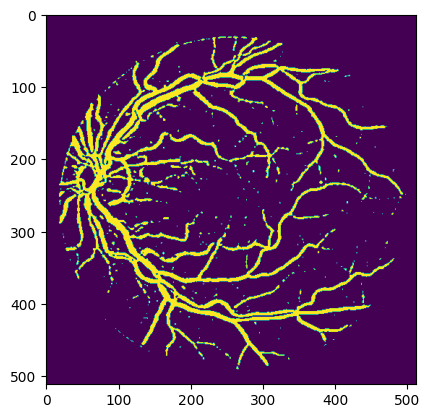

Loss train: 0.597	 Train dice: 0.335	, Train IOU: 0.20106790959835052
Loss train: 0.587	 Train dice: 0.336	, Train IOU: 0.2021225243806839
Loss train: 0.562	 Train dice: 0.338	, Train IOU: 0.20327112078666687
Loss train: 0.588	 Train dice: 0.339	, Train IOU: 0.20434021949768066
Loss train: 0.570	 Train dice: 0.341	, Train IOU: 0.20537225902080536
Loss train: 0.600	 Train dice: 0.342	, Train IOU: 0.20641590654850006
Loss train: 0.625	 Train dice: 0.343	, Train IOU: 0.20713534951210022
Loss train: 0.584	 Train dice: 0.345	, Train IOU: 0.208217591047287
Loss train: 0.592	 Train dice: 0.346	, Train IOU: 0.20925107598304749
Loss train: 0.570	 Train dice: 0.347	, Train IOU: 0.21011404693126678
Loss train: 0.567	 Train dice: 0.349	, Train IOU: 0.2111731618642807
Loss train: 0.583	 Train dice: 0.350	, Train IOU: 0.21210600435733795
Loss train: 0.567	 Train dice: 0.351	, Train IOU: 0.21303796768188477
Loss train: 0.555	 Train dice: 0.353	, Train IOU: 0.2140243947505951
Loss train: 0.592	 Train 

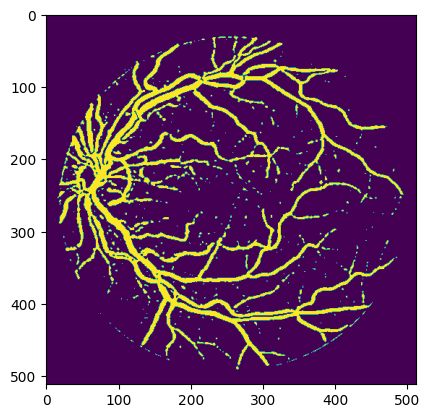

Loss train: 0.583	 Train dice: 0.361	, Train IOU: 0.2202940583229065
Loss train: 0.577	 Train dice: 0.362	, Train IOU: 0.22111457586288452
Loss train: 0.577	 Train dice: 0.363	, Train IOU: 0.222005695104599
Loss train: 0.575	 Train dice: 0.364	, Train IOU: 0.22285445034503937
Loss train: 0.568	 Train dice: 0.366	, Train IOU: 0.2237827330827713
Loss train: 0.557	 Train dice: 0.367	, Train IOU: 0.22453774511814117
Loss train: 0.555	 Train dice: 0.368	, Train IOU: 0.2253016084432602
Loss train: 0.579	 Train dice: 0.369	, Train IOU: 0.22621963918209076
Loss train: 0.601	 Train dice: 0.370	, Train IOU: 0.2269645631313324
Loss train: 0.568	 Train dice: 0.371	, Train IOU: 0.2278747409582138
Loss train: 0.597	 Train dice: 0.372	, Train IOU: 0.22874663770198822
Loss train: 0.630	 Train dice: 0.373	, Train IOU: 0.22911058366298676
Loss train: 0.585	 Train dice: 0.374	, Train IOU: 0.2298012524843216
Loss train: 0.550	 Train dice: 0.375	, Train IOU: 0.23067639768123627
Loss train: 0.545	 Train dic

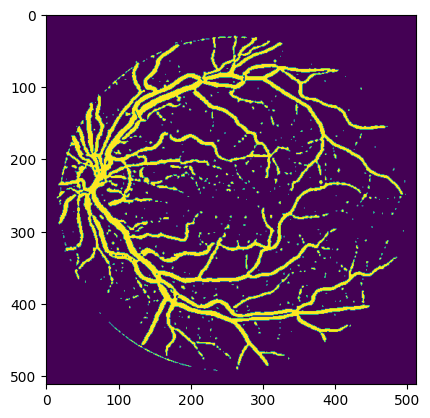

Loss train: 0.537	 Train dice: 0.382	, Train IOU: 0.23613131046295166
Loss train: 0.555	 Train dice: 0.383	, Train IOU: 0.2369082272052765
Loss train: 0.559	 Train dice: 0.384	, Train IOU: 0.2375805675983429
Loss train: 0.573	 Train dice: 0.385	, Train IOU: 0.23811174929141998
Loss train: 0.542	 Train dice: 0.386	, Train IOU: 0.23895324766635895
Loss train: 0.565	 Train dice: 0.387	, Train IOU: 0.239631786942482
Loss train: 0.522	 Train dice: 0.388	, Train IOU: 0.24042072892189026
Loss train: 0.571	 Train dice: 0.389	, Train IOU: 0.24109096825122833
Loss train: 0.563	 Train dice: 0.389	, Train IOU: 0.24172483384609222
Loss train: 0.516	 Train dice: 0.390	, Train IOU: 0.2425270974636078
Loss train: 0.518	 Train dice: 0.391	, Train IOU: 0.2433212250471115
Loss train: 0.565	 Train dice: 0.392	, Train IOU: 0.24381405115127563
Loss train: 0.583	 Train dice: 0.393	, Train IOU: 0.24449984729290009
Loss train: 0.516	 Train dice: 0.394	, Train IOU: 0.24525170028209686
Loss train: 0.548	 Train d

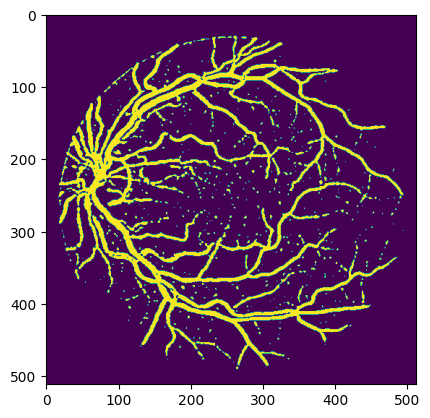

Loss train: 0.549	 Train dice: 0.400	, Train IOU: 0.24967725574970245
Loss train: 0.554	 Train dice: 0.400	, Train IOU: 0.250248521566391
Loss train: 0.544	 Train dice: 0.401	, Train IOU: 0.2508634626865387
Loss train: 0.534	 Train dice: 0.402	, Train IOU: 0.2515348792076111
Loss train: 0.530	 Train dice: 0.403	, Train IOU: 0.2520766854286194
Loss train: 0.554	 Train dice: 0.403	, Train IOU: 0.25260475277900696
Loss train: 0.596	 Train dice: 0.404	, Train IOU: 0.25328436493873596
Loss train: 0.568	 Train dice: 0.405	, Train IOU: 0.2537851333618164
Loss train: 0.548	 Train dice: 0.405	, Train IOU: 0.25418737530708313
Loss train: 0.580	 Train dice: 0.406	, Train IOU: 0.2548390030860901
Loss train: 0.576	 Train dice: 0.407	, Train IOU: 0.25533339381217957
Loss train: 0.553	 Train dice: 0.407	, Train IOU: 0.2558225095272064
Loss train: 0.557	 Train dice: 0.408	, Train IOU: 0.2564641535282135
Loss train: 0.524	 Train dice: 0.409	, Train IOU: 0.25704020261764526
Loss train: 0.529	 Train dice

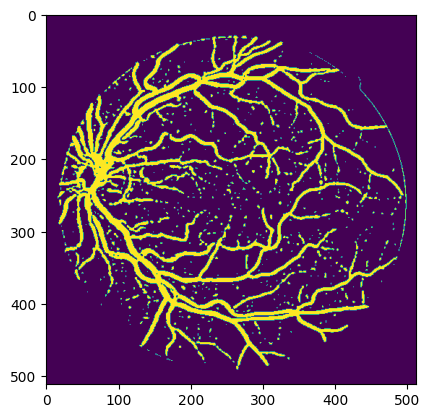

Loss train: 0.551	 Train dice: 0.414	, Train IOU: 0.26083892583847046
Loss train: 0.530	 Train dice: 0.415	, Train IOU: 0.2614642381668091
Loss train: 0.522	 Train dice: 0.415	, Train IOU: 0.26208263635635376
Loss train: 0.532	 Train dice: 0.416	, Train IOU: 0.262521892786026
Loss train: 0.575	 Train dice: 0.416	, Train IOU: 0.26297569274902344
Loss train: 0.526	 Train dice: 0.417	, Train IOU: 0.2635762393474579
Loss train: 0.569	 Train dice: 0.418	, Train IOU: 0.2639569342136383
Loss train: 0.546	 Train dice: 0.418	, Train IOU: 0.26455023884773254
Loss train: 0.546	 Train dice: 0.419	, Train IOU: 0.26494210958480835
Loss train: 0.516	 Train dice: 0.420	, Train IOU: 0.2654806077480316
Loss train: 0.555	 Train dice: 0.420	, Train IOU: 0.26602843403816223
Loss train: 0.553	 Train dice: 0.421	, Train IOU: 0.2665117681026459
Loss train: 0.537	 Train dice: 0.422	, Train IOU: 0.26706546545028687
Loss train: 0.528	 Train dice: 0.422	, Train IOU: 0.26754435896873474
Loss train: 0.518	 Train di

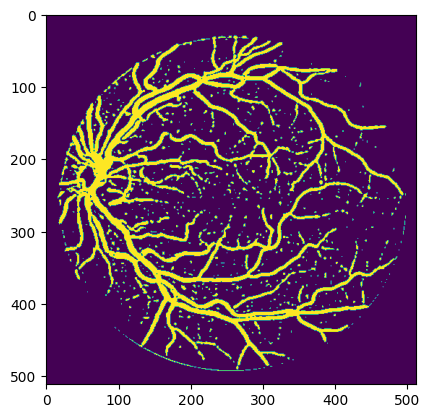

Loss train: 0.536	 Train dice: 0.426	, Train IOU: 0.2708486020565033
Loss train: 0.555	 Train dice: 0.427	, Train IOU: 0.27133116126060486
Loss train: 0.566	 Train dice: 0.427	, Train IOU: 0.2718520760536194
Loss train: 0.561	 Train dice: 0.428	, Train IOU: 0.27214932441711426
Loss train: 0.555	 Train dice: 0.428	, Train IOU: 0.27254754304885864
Loss train: 0.544	 Train dice: 0.429	, Train IOU: 0.27303069829940796
Loss train: 0.533	 Train dice: 0.429	, Train IOU: 0.27345868945121765
Loss train: 0.558	 Train dice: 0.430	, Train IOU: 0.2739144563674927
Loss train: 0.586	 Train dice: 0.431	, Train IOU: 0.2743223309516907
Loss train: 0.561	 Train dice: 0.431	, Train IOU: 0.27469244599342346
Loss train: 0.561	 Train dice: 0.431	, Train IOU: 0.2750679850578308
Loss train: 0.562	 Train dice: 0.432	, Train IOU: 0.2754524350166321
Loss train: 0.542	 Train dice: 0.432	, Train IOU: 0.27586641907691956
Loss train: 0.547	 Train dice: 0.433	, Train IOU: 0.27622127532958984
Loss train: 0.571	 Train d

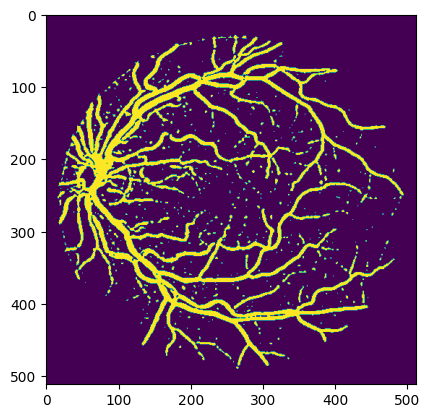

Loss train: 0.528	 Train dice: 0.436	, Train IOU: 0.27913787961006165
Loss train: 0.530	 Train dice: 0.437	, Train IOU: 0.2795698046684265
Loss train: 0.533	 Train dice: 0.437	, Train IOU: 0.2799169421195984
Loss train: 0.524	 Train dice: 0.438	, Train IOU: 0.2803921103477478
Loss train: 0.562	 Train dice: 0.438	, Train IOU: 0.28075554966926575
Loss train: 0.536	 Train dice: 0.439	, Train IOU: 0.2810435891151428
Loss train: 0.523	 Train dice: 0.439	, Train IOU: 0.28148317337036133
Loss train: 0.533	 Train dice: 0.440	, Train IOU: 0.28191810846328735
Loss train: 0.517	 Train dice: 0.440	, Train IOU: 0.2823631763458252
Loss train: 0.522	 Train dice: 0.441	, Train IOU: 0.2826381325721741
Loss train: 0.502	 Train dice: 0.441	, Train IOU: 0.28303393721580505
Loss train: 0.546	 Train dice: 0.442	, Train IOU: 0.28347569704055786
Loss train: 0.552	 Train dice: 0.442	, Train IOU: 0.28385666012763977
Loss train: 0.524	 Train dice: 0.443	, Train IOU: 0.2842273414134979
Loss train: 0.553	 Train di

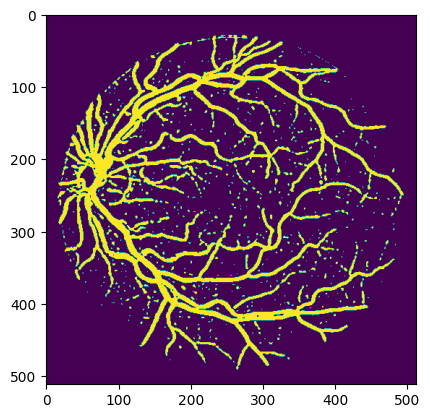

Loss train: 0.533	 Train dice: 0.446	, Train IOU: 0.28671422600746155
Loss train: 0.519	 Train dice: 0.446	, Train IOU: 0.28709131479263306
Loss train: 0.508	 Train dice: 0.447	, Train IOU: 0.28752920031547546
Loss train: 0.531	 Train dice: 0.447	, Train IOU: 0.2878628671169281
Loss train: 0.547	 Train dice: 0.447	, Train IOU: 0.28820565342903137
Loss train: 0.499	 Train dice: 0.448	, Train IOU: 0.2885681092739105
Loss train: 0.546	 Train dice: 0.448	, Train IOU: 0.2889082729816437
Loss train: 0.533	 Train dice: 0.449	, Train IOU: 0.2892468273639679
Loss train: 0.509	 Train dice: 0.449	, Train IOU: 0.28955939412117004
Loss train: 0.526	 Train dice: 0.450	, Train IOU: 0.28992003202438354
Loss train: 0.544	 Train dice: 0.450	, Train IOU: 0.2902575433254242
Loss train: 0.529	 Train dice: 0.450	, Train IOU: 0.2905758023262024
Loss train: 0.512	 Train dice: 0.451	, Train IOU: 0.29087668657302856
Loss train: 0.503	 Train dice: 0.451	, Train IOU: 0.2911970913410187
Loss train: 0.519	 Train di

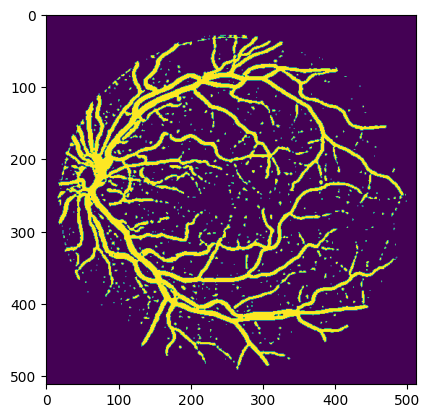

Loss train: 0.554	 Train dice: 0.454	, Train IOU: 0.29344436526298523
Loss train: 0.517	 Train dice: 0.454	, Train IOU: 0.2938282787799835
Loss train: 0.525	 Train dice: 0.455	, Train IOU: 0.294132262468338
Loss train: 0.508	 Train dice: 0.455	, Train IOU: 0.29447823762893677
Loss train: 0.525	 Train dice: 0.455	, Train IOU: 0.2947852313518524
Loss train: 0.493	 Train dice: 0.456	, Train IOU: 0.2951231300830841
Loss train: 0.564	 Train dice: 0.456	, Train IOU: 0.2954278290271759
Loss train: 0.527	 Train dice: 0.456	, Train IOU: 0.2956748306751251
Loss train: 0.522	 Train dice: 0.457	, Train IOU: 0.29583725333213806
Loss train: 0.562	 Train dice: 0.457	, Train IOU: 0.29616090655326843
Loss train: 0.524	 Train dice: 0.457	, Train IOU: 0.2964780628681183
Loss train: 0.544	 Train dice: 0.458	, Train IOU: 0.2966265380382538
Loss train: 0.524	 Train dice: 0.458	, Train IOU: 0.29681330919265747
Loss train: 0.559	 Train dice: 0.458	, Train IOU: 0.29719164967536926
Loss train: 0.523	 Train dice

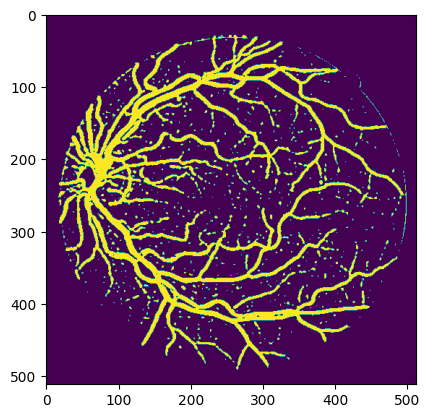

Loss train: 0.511	 Train dice: 0.461	, Train IOU: 0.2991705536842346
Loss train: 0.557	 Train dice: 0.461	, Train IOU: 0.29936814308166504
Loss train: 0.519	 Train dice: 0.461	, Train IOU: 0.29967647790908813
Loss train: 0.537	 Train dice: 0.461	, Train IOU: 0.29996737837791443
Loss train: 0.513	 Train dice: 0.462	, Train IOU: 0.3001757264137268
Loss train: 0.506	 Train dice: 0.462	, Train IOU: 0.3004235029220581
Loss train: 0.514	 Train dice: 0.462	, Train IOU: 0.30077409744262695
Loss train: 0.503	 Train dice: 0.463	, Train IOU: 0.30109167098999023
Loss train: 0.506	 Train dice: 0.463	, Train IOU: 0.30125191807746887
Loss train: 0.517	 Train dice: 0.463	, Train IOU: 0.3016112744808197
Loss train: 0.530	 Train dice: 0.464	, Train IOU: 0.30185386538505554
Loss train: 0.546	 Train dice: 0.464	, Train IOU: 0.3020474314689636
Loss train: 0.522	 Train dice: 0.464	, Train IOU: 0.30233195424079895
Loss train: 0.533	 Train dice: 0.465	, Train IOU: 0.30264362692832947
Loss train: 0.533	 Train 

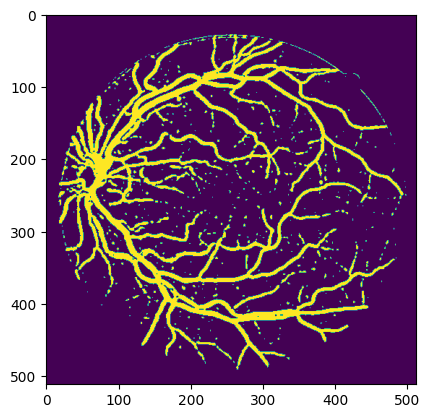

Loss train: 0.487	 Train dice: 0.467	, Train IOU: 0.30443257093429565
Loss train: 0.551	 Train dice: 0.467	, Train IOU: 0.3047769367694855
Loss train: 0.568	 Train dice: 0.467	, Train IOU: 0.30483490228652954
Loss train: 0.512	 Train dice: 0.468	, Train IOU: 0.3050697147846222
Loss train: 0.500	 Train dice: 0.468	, Train IOU: 0.305404394865036
Loss train: 0.540	 Train dice: 0.468	, Train IOU: 0.3056548535823822
Loss train: 0.519	 Train dice: 0.468	, Train IOU: 0.3058709502220154
Loss train: 0.536	 Train dice: 0.469	, Train IOU: 0.3061484098434448
Loss train: 0.521	 Train dice: 0.469	, Train IOU: 0.30637332797050476
Loss train: 0.563	 Train dice: 0.469	, Train IOU: 0.3065059185028076
Loss train: 0.509	 Train dice: 0.470	, Train IOU: 0.30677855014801025
Loss train: 0.516	 Train dice: 0.470	, Train IOU: 0.3070260286331177
Loss train: 0.522	 Train dice: 0.470	, Train IOU: 0.3071662485599518
Loss train: 0.502	 Train dice: 0.470	, Train IOU: 0.30746403336524963
Loss train: 0.543	 Train dice:

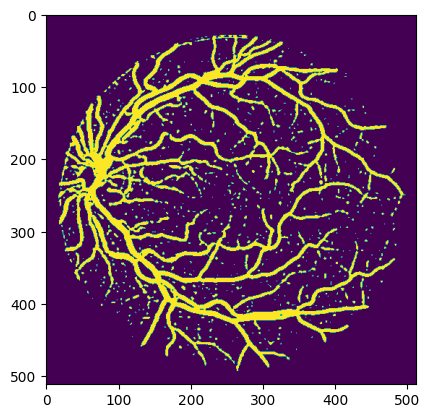

Loss train: 0.528	 Train dice: 0.472	, Train IOU: 0.30909302830696106
Loss train: 0.556	 Train dice: 0.473	, Train IOU: 0.30936625599861145


In [ ]:
out_dict, metric_dict = train(model, optim.Adam(model.parameters(), 0.001), loss_fn, 500, train_loader, test_loader, test_loader)

In [ ]:
# out_dict

In [ ]:
im, lab = next(iter(test_loader))
out = model(im.cuda())
plt.imshow(F.sigmoid(out)[0].squeeze().detach().cpu() > 0.5)